# 태양광
***
### 3년(Day 0 ~ Day 1094) 동안의 기상 데이터, 발전량(TARGET) 데이터

### test는 2년동안의 기상데이터, 발전량(TARGET) 데이터

### 각 파일의 7일 동안의 데이터 전체 혹은 일부 활용하여 향후 2일 동안의 30분 간격 발전량 예측
****
- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
- DNI - 직달일사량(Direct Normal Irradiance (W/m2))
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [7]:
!pip install scikit-garden

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import time

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg as qreg
import statsmodels.formula.api as smf

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from skgarden import RandomForestQuantileRegressor, DecisionTreeQuantileRegressor, ExtraTreeQuantileRegressor, ExtraTreesQuantileRegressor

In [365]:
cd /content/gdrive/My Drive/dacon/sun/data/train

/content/gdrive/My Drive/dacon/sun/data/train


In [366]:
train = pd.read_csv('train.csv')

In [367]:
cd /content/gdrive/My Drive/dacon/sun/data/test

/content/gdrive/My Drive/dacon/sun/data/test


In [368]:
for i in range(81) :
    globals() [f'test_{i}'] = pd.read_csv(f'{i}.csv')
    globals() [f'test_{i}']['sep_day'] = i

In [369]:
### 각 데이터를 하나의 데이터로 통합
test = pd.DataFrame()
idx_list = []
for i in range(81):
  test = pd.concat([test, globals()[f'test_{i}']], axis = 0, ignore_index = True)

In [370]:
cd /content/gdrive/My Drive/dacon/sun/data

/content/gdrive/My Drive/dacon/sun/data


In [371]:
submission = pd.read_csv('sample_submission.csv')

In [260]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [261]:
test.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,sep_day
0,0,0,0,0,0,2.7,34.42,0.0,0.0,0
1,0,0,30,0,0,2.7,34.17,0.1,0.0,0
2,0,1,0,0,0,2.7,34.23,0.2,0.0,0
3,0,1,30,0,0,2.7,33.99,0.3,0.0,0
4,0,2,0,0,0,2.8,33.97,0.4,0.0,0


In [372]:
tr_times = []
for day in train.Day.unique() :
  d = train.loc[train.Day == day]
  try :
    start = d.loc[d.DNI > 0].index[0]
    end = d.loc[d.DNI > 0].index[-1]
    gap = end - start
  except :
    gap = 0

  tr_times.append(gap)

In [373]:
te_times = []
for day in test.Day.unique() :
  d = test.loc[train.Day == day]
  try :
    start = d.loc[d.DNI > 0].index[0]
    end = d.loc[d.DNI > 0].index[-1]
    gap = end - start
  except :
    gap = 0
  
  te_times.append(gap)

In [374]:
train_sun_time = pd.DataFrame({'Day' : train.Day.unique(), 'sun_time' : tr_times})
test_sun_time = pd.DataFrame({'Day' : test.Day.unique(), 'sun_time' : te_times})

In [375]:
train = pd.merge(train, train_sun_time, how = 'left', on = 'Day')
test = pd.merge(test, test_sun_time, how = 'left', on = 'Day')

In [379]:
def season(x) :
  if x >= 24 :
    return 'summer'
  elif 5 <= x < 24 :
    return 'spring_or_fall'
  else :
    return 'winter'

In [380]:
train_temp_mean = train.groupby('Day')['T'].mean().reset_index(name = 'temp_mean')
train_temp_mean['season'] = train_temp_mean['temp_mean'].apply(season)

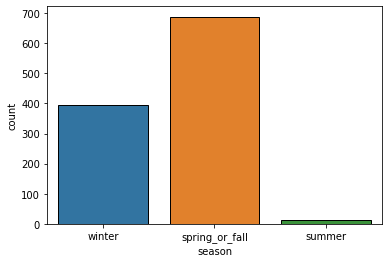

In [381]:
sns.countplot(train_temp_mean.season, edgecolor = (0,0,0))
plt.show()

In [382]:
train = pd.merge(train, train_temp_mean, how = 'left', on = 'Day')

In [383]:
test_temp_mean = test.groupby('sep_day')['T'].mean().reset_index(name = 'temp_mean')
test_temp_mean['season'] = test_temp_mean['temp_mean'].apply(season)

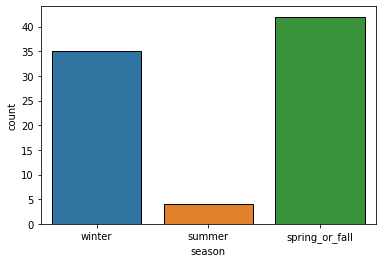

In [384]:
sns.countplot(test_temp_mean.season, edgecolor = (0,0,0))
plt.show()

In [385]:
test = pd.merge(test, test_temp_mean, how = 'left', on = 'sep_day')

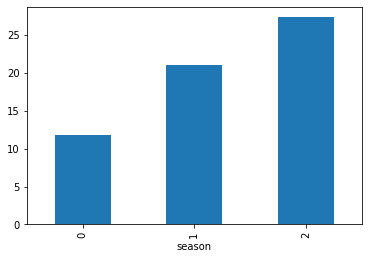

In [336]:
train.groupby('season').TARGET.mean().plot(kind = 'bar')
plt.show()

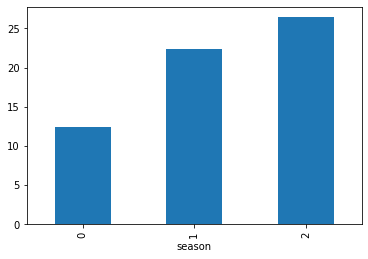

In [335]:
test.groupby('season').TARGET.mean().plot(kind = 'bar')
plt.show()

In [386]:
train.season = train.season.map({'summer' : 2, 'spring_or_fall' : 1, 'winter' : 0})
test.season = test.season.map({'summer' : 2, 'spring_or_fall' : 1, 'winter' : 0})

In [387]:
train['eff_gap'] = [.05 * (x - 25) if x > 25 else 0 for x in train['T']]
test['eff_gap'] = [.05 * (x - 25) if x > 25 else 0 for x in test['T']]

In [388]:
train['DNI'] = np.log1p(train['DNI'])
train['DHI'] = np.log1p(train['DHI'])
train['WS'] = np.log1p(train['WS'])

In [389]:
test['DNI'] = np.log1p(test['DNI'])
test['DHI'] = np.log1p(test['DHI'])
test['WS'] = np.log1p(test['WS'])

In [390]:
train.Minute = train.Minute.map({30 : 1, 0: 0})
test.Minute = test.Minute.map({30 : 1, 0: 0})

In [391]:
train['hour_mean'] = train.Hour.map(train.groupby('Hour').TARGET.mean())
test['hour_mean'] = test.Hour.map(test.groupby('Hour').TARGET.mean())

In [392]:
train['day_mean'] = train.Day.map(train.groupby('Day').TARGET.mean())
test['day_mean'] = test.Day.map(test.groupby('Day').TARGET.mean())

In [393]:
train_after_2 = train.loc[train.Day <= 1092]
train_after_2['TARGET2'] = list(train.loc[train.Day >= 2].TARGET)
train_after_2['Day'] = train_after_2.Day % 9

In [395]:
train_after_2.drop(['Day', 'Hour', 'Minute'], axis =1 ,inplace = True)
test.drop('sep_day', axis = 1, inplace = True)

In [396]:
target1 = test.query('Day in [0, 1]').drop(['Day','Hour', 'Minute'], axis =1)
target2 = test.query('Day in [1, 2]').drop(['Day','Hour', 'Minute'], axis =1)
target3 = test.query('Day in [2, 3]').drop(['Day','Hour', 'Minute'], axis =1)
target4 = test.query('Day in [3, 4]').drop(['Day','Hour', 'Minute'], axis =1)

target_list = [target1, target2, target3, target4]

In [397]:
actual1 = test.query('Day in [2,3]').TARGET
actual2 = test.query('Day in [3,4]').TARGET
actual3 = test.query('Day in [4,5]').TARGET
actual4 = test.query('Day in [5,6]').TARGET

actual_list = [actual1, actual2, actual3, actual4]

In [400]:
target = test.query('Day in [5,6]').drop(['Day','Hour', 'Minute'], axis = 1)

In [86]:
def pb_loss(true, pred, q) :
    
    L_list = []
    
    for i in range(len(true)) :
        
        if true.iloc[i] >= pred[i] :
            L = true.iloc[i] - pred[i]
            L *= q
            
        else :
            L1 = pred[i] - true.iloc[i]
            L2 = 1 - q
            L = L1 * L2
            
        L_list.append(L)
        
    return np.mean(L_list)

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [31]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [401]:
scaler = StandardScaler()
train_after_2[['RH', "T"]] = scaler.fit_transform(train_after_2[['RH','T']])

In [402]:
tr_X = train_after_2.drop('TARGET2', axis = 1).iloc[:int(train.shape[0] * .8), :]
tr_y = train_after_2.TARGET2.iloc[:int(train.shape[0] * .8)]

val_X = train_after_2.drop('TARGET2', axis = 1).iloc[int(train.shape[0] * .8):, :]
val_y = train_after_2.TARGET2.iloc[int(train.shape[0] * .8):]

In [403]:
test[['RH','T']] = scaler.transform(test[['RH','T']])

In [404]:
target1 = test.query('Day in [0, 1]').drop(['Day', 'Hour', 'Minute'], axis =1)
target2 = test.query('Day in [1, 2]').drop(['Day', 'Hour', 'Minute'], axis =1)
target3 = test.query('Day in [2, 3]').drop(['Day', 'Hour', 'Minute'], axis =1)
target4 = test.query('Day in [3, 4]').drop(['Day', 'Hour', 'Minute'], axis =1)

target_list = [target1, target2, target3, target4]

target = test.query('Day in [5,6]').drop(['Day', 'Hour', 'Minute'], axis = 1)

In [405]:
for i, data in enumerate(zip(target_list, actual_list)) :
  print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
  for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    pb_loss_list = []
    n = int(q * 10)
    print(f'quantile {q} regression start')
    model = keras.Sequential([
    Dense(32, activation='relu', input_shape=[tr_X.shape[1]]),
    Dropout(.3),
    Dense(32, activation='relu'),
    Dense(1)])
    optimizer = tf.keras.optimizers.RMSprop(0.0005)
    es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True, verbose = 0)
    mc = ModelCheckpoint(f'1218keras_{n}.h5', mode = 'min', monitor = 'val_loss', patience = 3, save_weights_only = True, verbose = 0)
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    
    model.fit(tr_X, tr_y, epochs=30, batch_size=32, verbose=0, validation_data = (val_X, val_y), callbacks = [es, mc])
    model.load_weights(f'1218keras_{n}.h5')
    
    pred = model.predict(data[0]).reshape(-1)
    pred = [0 if x < 0 else x for x in pred]
    loss = pb_loss(data[1], pred, q)
    pb_loss_list.append(loss)
  print(f'평균 loss는 {np.mean(pb_loss_list)}')

1번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regression start
quantile 0.2 regression start
quantile 0.3 regression start
quantile 0.4 regression start
quantile 0.5 regression start
quantile 0.6 regression start
quantile 0.7 regression start
quantile 0.8 regression start
quantile 0.9 regression start
평균 loss는 1.3289383471886769
2번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regression start
quantile 0.2 regression start
quantile 0.3 regression start
quantile 0.4 regression start
quantile 0.5 regression start
quantile 0.6 regression start
quantile 0.7 regression start
quantile 0.8 regression start
quantile 0.9 regression start
평균 loss는 1.3506878660366797
3번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regression start
quantile 0.2 regression start
quantile 0.3 regression start
quantile 0.4 regression start
quantile 0.5 regression start
quantile 0.6 regression start
quantile 0.7 regression start
quantile 0.8 regression start
quantile 0.9 regression start
평균 loss는 1.179703712177776
4번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regres

In [ ]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    n = int(q * 10)
    model = keras.Sequential([
    Dense(32, activation='relu', input_shape=[tr_X.shape[1]]),
    Dropout(.3),
    Dense(32, activation='relu'),
    Dense(1)])
    model.load_weights(f'1218keras_{n}.h5')
    pred = model.predict(data[0]).reshape(-1)
    pred = [0 if x < 0 else x for x in pred]
    submission[f'q_{q}'] = pred
keras_submission = submission.copy()

In [ ]:
keras_submission 

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.032315,0.000000
1,0.csv_Day7_0h30m,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.032007,0.000000
2,0.csv_Day7_1h00m,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.031668,0.000000
3,0.csv_Day7_1h30m,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.031746,0.000000
4,0.csv_Day7_2h00m,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.031689,0.000000
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.013312,0.0,0.0,0.046152,0.0,0.051632,0.058584
7772,80.csv_Day8_22h00m,0.0,0.0,0.012832,0.0,0.0,0.043391,0.0,0.043419,0.046150
7773,80.csv_Day8_22h30m,0.0,0.0,0.012373,0.0,0.0,0.039166,0.0,0.038550,0.033107
7774,80.csv_Day8_23h00m,0.0,0.0,0.011996,0.0,0.0,0.037589,0.0,0.032456,0.023755


In [ ]:
keras_submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,5.393203,8.492019,11.900003,13.966566,15.822503,17.463965,19.158274,20.023084,26.798681
std,7.470355,11.562747,16.119714,18.401180,20.257282,21.839972,23.622877,24.150015,31.300803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.002433,0.000000,0.000000,0.000000,0.000000,0.034813,0.021617
50%,0.042945,0.139790,0.297398,0.445135,1.141936,1.868695,1.990904,3.244309,7.560732
75%,10.394801,16.137550,22.858497,28.071254,32.356520,36.496115,41.251954,42.873041,57.032084
max,28.142572,43.003899,61.105003,67.528259,71.654579,74.502640,75.773888,81.720047,96.256210


In [406]:
X = train_after_2.drop('TARGET2', axis = 1)
y = train_after_2.TARGET2

In [407]:
for i, data in enumerate(zip(target_list, actual_list)) :
    loss_list = []
    print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
    for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :

      quantreg = sm.QuantReg(y, X)
      pred = [0 if x < 0 else x for x in quantreg.fit(qt).predict(data[0])]

      loss = pb_loss(data[1], pred, qt)
      loss_list.append(loss)
      print(f'{qt} quantile pinball_loss는 {np.mean(loss_list)}')      

1번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.4108016175261002
0.2 quantile pinball_loss는 1.8488034113154965
0.3 quantile pinball_loss는 2.163497500303707
0.4 quantile pinball_loss는 2.369940847754573
0.5 quantile pinball_loss는 2.4764365869268556
0.6 quantile pinball_loss는 2.497167582004319
0.7 quantile pinball_loss는 2.452112205003654
0.8 quantile pinball_loss는 2.351799367889657
0.9 quantile pinball_loss는 2.1995029870744403
2번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.404681396029594
0.2 quantile pinball_loss는 1.88016088931034
0.3 quantile pinball_loss는 2.2355590608080917
0.4 quantile pinball_loss는 2.4693429289772575
0.5 quantile pinball_loss는 2.592749177972812
0.6 quantile pinball_loss는 2.6218898358642684
0.7 quantile pinball_loss는 2.5784980105364927
0.8 quantile pinball_loss는 2.4758552380299204
0.9 quantile pinball_loss는 2.3164798096035466
3번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.5249825708810318
0.2 quantile pinball_loss는 2.088314941567977
0.3 quantile pinball_los

In [409]:
for i, data in enumerate(zip(target_list, actual_list)) :
    loss_list = []
    print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
    for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
        
        gbm = GradientBoostingRegressor(random_state = 1216, max_depth = 4, loss = 'quantile', alpha = qt)
        gbm.fit(X, y)

        pred = gbm.predict(data[0])

        loss = pb_loss(data[1], pred, qt)
        loss_list.append(loss)
        print(f'{qt} quantile pinball_loss는 {np.mean(loss_list)}')

1번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.454269039145502
0.2 quantile pinball_loss는 1.9323452323658892
0.3 quantile pinball_loss는 2.231302007471864
0.4 quantile pinball_loss는 2.4188676657465455
0.5 quantile pinball_loss는 2.4990948545318776
0.6 quantile pinball_loss는 2.504140493146037
0.7 quantile pinball_loss는 2.450547382850611
0.8 quantile pinball_loss는 2.3495665982657634
0.9 quantile pinball_loss는 2.2050117002570584
2번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.469926418389696
0.2 quantile pinball_loss는 1.9991185406177685
0.3 quantile pinball_loss는 2.328100110854477
0.4 quantile pinball_loss는 2.527511832055257
0.5 quantile pinball_loss는 2.618044973444823
0.6 quantile pinball_loss는 2.6321458413112375
0.7 quantile pinball_loss는 2.580443568214846
0.8 quantile pinball_loss는 2.4759059299473565
0.9 quantile pinball_loss는 2.3205091210387447
3번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.5646071741897614
0.2 quantile pinball_loss는 2.1095878183050925
0.3 quantile pinball_lo

In [410]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    
    gbm = GradientBoostingRegressor(random_state = 1216, loss = 'quantile', alpha = q)
    gbm.fit(X, y)

    gbm_pred = gbm.predict(target)
    submission[f'q_{q}'] = gbm_pred
gbm_submission = submission.copy()

In [411]:
gbm_submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002299


In [417]:
for i, data in enumerate(zip(target_list, actual_list)) :
    loss_list = []
    print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
    for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :

        lgbm = LGBMRegressor(random_state = 1218, max_depth = 4, objective = 'quantile', metric = 'quantile', alpha = qt)
        lgbm.fit(X, y)

        pred = lgbm.predict(data[0])

        loss = pb_loss(data[1], pred, qt)

        loss_list.append(loss)
        print(f'{qt} quantile pinball_loss는 {np.mean(loss_list)}')

1번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.4288055731399927
0.2 quantile pinball_loss는 1.886747488775805
0.3 quantile pinball_loss는 2.196574841064874
0.4 quantile pinball_loss는 2.383817700438793
0.5 quantile pinball_loss는 2.4745622242386647
0.6 quantile pinball_loss는 2.4824082897041375
0.7 quantile pinball_loss는 2.4313488718467084
0.8 quantile pinball_loss는 2.3344660137277096
0.9 quantile pinball_loss는 2.190799505715389
2번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.443514416101745
0.2 quantile pinball_loss는 1.9598361562926914
0.3 quantile pinball_loss는 2.2952743213945856
0.4 quantile pinball_loss는 2.4936028401451975
0.5 quantile pinball_loss는 2.5912941274687724
0.6 quantile pinball_loss는 2.6099657933757037
0.7 quantile pinball_loss는 2.5596639916905017
0.8 quantile pinball_loss는 2.459991533725575
0.9 quantile pinball_loss는 2.3059612259623723
3번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.5601963355836586
0.2 quantile pinball_loss는 2.0972685364357955
0.3 quantile pinball

In [413]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    
    lgbm = LGBMRegressor(random_state = 1218, objective = 'quantile', metric = 'quantile', alpha = q)
    lgbm.fit(X, y)

    lgbm_pred = lgbm.predict(data[0])
    submission[f'q_{q}'] = lgbm_pred
lgbm_submission = submission.copy()

In [ ]:
keras_submission.iloc[:, 1:] *= .4
lgbm_submission.iloc[:, 1:] *= .2
gbm_submission.iloc[:, 1:] *= .4

In [ ]:
submission.iloc[:, 1:] = lgbm_submission.iloc[:, 1:] + gbm_submission.iloc[:, 1:] + keras_submission.iloc[:, 1:]

In [ ]:
submission.iloc[:, 1:] = submission.iloc[:, 1:].applymap(lambda x : 0 if x < 0 else x)

In [ ]:
submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,6.095077,10.208887,13.989474,16.311521,18.184547,19.588074,21.027051,22.158061,25.944825
std,8.248503,13.442594,18.173177,21.158142,23.152764,24.641844,26.198610,27.080559,30.652147
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000142,0.000000,0.000000,0.001326
25%,0.000000,0.000000,0.000997,0.000000,0.000000,0.000142,0.000372,0.014586,0.010050
50%,0.194720,0.388088,0.821742,0.863570,1.430941,1.988183,2.599526,3.350001,5.768806
75%,12.515031,21.276728,29.498494,34.089188,37.933423,40.665967,43.759506,46.824790,54.925541
max,31.596948,48.690731,60.353096,69.737799,74.260325,77.848500,81.590329,84.700136,94.296276


In [ ]:
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.000000,0.0,0.0,0.000142,0.000372,0.013584,0.001326
1,0.csv_Day7_0h30m,0.0,0.0,0.000000,0.0,0.0,0.000142,0.000372,0.013461,0.001326
2,0.csv_Day7_1h00m,0.0,0.0,0.000000,0.0,0.0,0.000142,0.000372,0.013325,0.001326
3,0.csv_Day7_1h30m,0.0,0.0,0.000000,0.0,0.0,0.000142,0.000372,0.013357,0.001326
4,0.csv_Day7_2h00m,0.0,0.0,0.000000,0.0,0.0,0.000142,0.000372,0.013334,0.001326
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.005325,0.0,0.0,0.018603,0.000372,0.021311,0.024759
7772,80.csv_Day8_22h00m,0.0,0.0,0.005133,0.0,0.0,0.017498,0.000372,0.018026,0.019786
7773,80.csv_Day8_22h30m,0.0,0.0,0.004949,0.0,0.0,0.015808,0.000372,0.016078,0.014569
7774,80.csv_Day8_23h00m,0.0,0.0,0.004798,0.0,0.0,0.015178,0.000372,0.013641,0.010828


In [ ]:
submission.to_csv('1218_2nd.csv', index = False)